In [64]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon

from Functions import pivot_data_by_HSA, merge_and_rename_data, add_changes_by_week, create_column_names, create_collated_weekly_data,prep_training_test_data, cross_validation_leave_geo_out, calculate_metrics, add_labels_to_subplots,prep_training_test_data, calculate_maximum_reget
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']

In [65]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")

# Polygons for mapping onto waves

In [66]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_64045/4200828156.py:4: DtypeWarning: Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')


# Threshold of 10 per 100k

In [4]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_10_100k'] = (data_by_HSA['beds_weekly'] > 10)*1


for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_deaths = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_icu = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_10_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_10_100k')

## merge 
data_by_HSA_cases_deaths = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_deaths,'week','cases', 'deaths')
data_by_HSA_admits_icu_weekly = merge_and_rename_data(data_by_HSA_admissions, data_by_HSA_icu,'week','admits', 'icu')
data_by_HSA_beds_perc_weekly = merge_and_rename_data(data_by_HSA_beds, data_by_HSA_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_cases_deaths_admits_icu = pd.merge(data_by_HSA_cases_deaths, data_by_HSA_admits_icu_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu, data_by_HSA_beds_perc_weekly, on='week')

## add outcome variable 

old_column_names = data_by_HSA_over_10_100k.columns
new_column_names = [str(col) + '_beds_over_10_100k' for col in old_column_names]
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_10_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA_over_10_100k, on='week')

data_by_HSA_cases_deaths_admits_icu_beds = data_by_HSA_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_cases_deaths_admits_icu_beds.columns = data_by_HSA_cases_deaths_admits_icu_beds.columns.str.replace(',', '')

## Add changes by week 
all_HSA_ID_weekly_data = add_changes_by_week(data_by_HSA_cases_deaths_admits_icu_beds, "beds_over_10_100k")


categories_for_subsetting = ['cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid', 'cases_delta', 'deaths_delta', 'admits_delta', 'icu_delta', 'beds_delta', 'perc_covid_delta','beds_over_10_100k']
num_of_weeks = len(data_by_HSA_cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

## Collate weekly data
all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

## Add weights
weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2200/642583283.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:348: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:348: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(ax

In [26]:
all_HSA_ID_weekly_data.to_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_10_per_100_incl_NA.csv')

# Threshold of 5 per 100k 

In [27]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_5_100k'] = (data_by_HSA['beds_weekly'] > 5)*1  # Changed 10 to 5


for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_deaths = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_icu = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_5_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_5_100k')  # Changed 10 to 5

## merge 
data_by_HSA_cases_deaths = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_deaths,'week','cases', 'deaths')
data_by_HSA_admits_icu_weekly = merge_and_rename_data(data_by_HSA_admissions, data_by_HSA_icu,'week','admits', 'icu')
data_by_HSA_beds_perc_weekly = merge_and_rename_data(data_by_HSA_beds, data_by_HSA_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_cases_deaths_admits_icu = pd.merge(data_by_HSA_cases_deaths, data_by_HSA_admits_icu_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu, data_by_HSA_beds_perc_weekly, on='week')

## add outcome variable 

old_column_names = data_by_HSA_over_5_100k.columns  # Changed 10 to 5
new_column_names = [str(col) + '_beds_over_5_100k' for col in old_column_names]  # Changed 10 to 5
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_5_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA_over_5_100k, on='week')  # Changed 10 to 5

data_by_HSA_cases_deaths_admits_icu_beds = data_by_HSA_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_cases_deaths_admits_icu_beds.columns = data_by_HSA_cases_deaths_admits_icu_beds.columns.str.replace(',', '')

all_HSA_ID_weekly_data = add_changes_by_week(data_by_HSA_cases_deaths_admits_icu_beds, "beds_over_5_100k")  # Changed 10 to 5

categories_for_subsetting = ['cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid', 'cases_delta', 'deaths_delta', 'admits_delta', 'icu_delta', 'beds_delta', 'perc_covid_delta','beds_over_5_100k']  # Changed 10 to 5
num_of_weeks = len(data_by_HSA_cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_19368/424546821.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

In [28]:
all_HSA_ID_weekly_data.to_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_5_per_100_incl_NA.csv')

# Threshold of 20 per 100k 

In [29]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_20_100k'] = (data_by_HSA['beds_weekly'] > 20)*1  # Changed 10 to 5

# remove HSAs that have missing data in specific columns

for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_deaths = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'deaths_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_icu = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'icu_weekly')
data_by_HSA_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_20_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_20_100k')  # Changed 10 to 5

## merge 
data_by_HSA_cases_deaths = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_deaths,'week','cases', 'deaths')
data_by_HSA_admits_icu_weekly = merge_and_rename_data(data_by_HSA_admissions, data_by_HSA_icu,'week','admits', 'icu')
data_by_HSA_beds_perc_weekly = merge_and_rename_data(data_by_HSA_beds, data_by_HSA_percent_beds,'week','beds', 'perc_covid')
data_by_HSA_cases_deaths_admits_icu = pd.merge(data_by_HSA_cases_deaths, data_by_HSA_admits_icu_weekly, on='week')
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu, data_by_HSA_beds_perc_weekly, on='week')

## add outcome variable 

old_column_names = data_by_HSA_over_20_100k.columns 
new_column_names = [str(col) + '_beds_over_20_100k' for col in old_column_names] 
new_column_names = dict(zip(old_column_names, new_column_names))
data_by_HSA_over_20_100k.rename(columns=new_column_names, inplace=True)
data_by_HSA_cases_deaths_admits_icu_beds = pd.merge(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA_over_20_100k, on='week')  

data_by_HSA_cases_deaths_admits_icu_beds = data_by_HSA_cases_deaths_admits_icu_beds.reset_index()
data_by_HSA_cases_deaths_admits_icu_beds.columns = data_by_HSA_cases_deaths_admits_icu_beds.columns.str.replace(',', '')

all_HSA_ID_weekly_data = add_changes_by_week(data_by_HSA_cases_deaths_admits_icu_beds, "beds_over_20_100k") 

categories_for_subsetting = ['cases', 'deaths', 'admits', 'icu', 'beds', 'perc_covid', 'cases_delta', 'deaths_delta', 'admits_delta', 'icu_delta', 'beds_delta', 'perc_covid_delta','beds_over_20_100k']  # Changed 10 to 5
num_of_weeks = len(data_by_HSA_cases_deaths_admits_icu_beds)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_deaths_admits_icu_beds, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_19368/1640321631.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data_frame.insert(column_index + 1, new_column_name, diff)
/Users/rem76/Documents/COVID_projections/COVID_forecasting/Functions.py:366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

In [30]:
all_HSA_ID_weekly_data.to_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_20_per_100_incl_NA.csv')

# Metrics for an expanding dataset

In [87]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'exact'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  

no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 -1 )

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [69]:
threshold_5_data = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_5_per_100_incl_NA.csv')
threshold_10_data = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_10_per_100_incl_NA.csv')
threshold_20_data = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_20_per_100_incl_NA.csv')



In [93]:
threshold_data = [threshold_5_data, threshold_10_data, threshold_20_data]
threshold_names = ['5', '10', '20']

exceed_threshold = {}

for threshold, name in zip(threshold_data, threshold_names):
    exceed_threshold[f'percent_exceed_capacity_{name}'] = []

    for column_name in threshold.columns:
        if f'beds_over_{name}_100k' in column_name:
            column_sum = threshold[column_name].sum() / len(threshold[column_name])
            exceed_threshold[f'percent_exceed_capacity_{name}'].append(column_sum)

In [71]:
working_directory = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_15_per_100k/Full_models_period_sensitivity_threshold/"

In [89]:

ROC_thresholds = {}
accuracy_thresholds = {}
MCC_thresholds = {}
size_of_test_dataset = 1

hospital_thresholds = [10,20]

for hospital_threshold in hospital_thresholds:
    dataset = f"threshold_{hospital_threshold}_data"
    ROC_list = f"ROC_by_week_full_exact_{hospital_threshold}"
    accuracy_list = f"accuracy_by_week_full_exact_{hospital_threshold}"
    MCC_list = f"MCC_by_week_full_exact_{hospital_threshold}"

    ROC_thresholds[ROC_list] = []
    accuracy_thresholds[accuracy_list] = []
    MCC_thresholds[MCC_list] = []
    
    for prediction_week in weeks_to_predict:
        model_name_to_load = working_directory + "Full_model_smaller_hyperparameters_" + time_period + "_" + str(prediction_week) + "_" + str(hospital_threshold) + "_per_100"  + ".sav"
        clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

        print(prediction_week)

        #period    

        X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(globals()[dataset], no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

        X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(globals()[dataset], no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        weights_full = weights_full[0].to_numpy()
        clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

        # Make predictions on the test set
        y_pred = clf_full_period.predict(X_test_full)
        y_pred_proba = clf_full_period.predict_proba(X_test_full)

        # Evaluate the accuracy of the model
        accuracy_thresholds[accuracy_list].append(accuracy_score(y_test_full, y_pred))
        ROC_thresholds[ROC_list].append(roc_auc_score(y_test_full, y_pred_proba[:, 1]))
        conf_matrix = confusion_matrix(y_test_full, y_pred)
        MCC_thresholds[MCC_list].append((matthews_corrcoef(y_test_full, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


# Naive classifier threhsold analysis

In [ ]:

ROC_thresholds_naive = {}
accuracy_thresholds_naive = {}
MCC_thresholds_naive = {}
size_of_test_dataset = 1

hospital_thresholds = [10,20]

for hospital_threshold in hospital_thresholds:
    dataset_name  = f"threshold_{hospital_threshold}_data"
    dataset  = globals()[dataset_name]
    columns_to_select = dataset.filter(regex=f'HSA|beds_over_{hospital_threshold}_100k|weight').columns.tolist()
    dataset = dataset[columns_to_select]
    ROC_list = f"ROC_by_week_naive_period_{hospital_threshold}"
    accuracy_list = f"accuracy_by_week_naive_period_{hospital_threshold}"
    MCC_list = f"MCC_by_week_naive_period_{hospital_threshold}"

    ROC_thresholds_naive[ROC_list] = []
    accuracy_thresholds_naive[accuracy_list] = []
    MCC_thresholds_naive[MCC_list] = []

    for prediction_week in weeks_to_predict:

        print(prediction_week)


        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(dataset, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(dataset, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        weights_naive = weights_naive[0].to_numpy()
        clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model
        accuracy_thresholds_naive[accuracy_list].append(accuracy_score(y_test_naive, y_pred))
        ROC_thresholds_naive[ROC_list].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
        MCC_thresholds_naive[MCC_list].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


# CDC A and B Threshold Analysis 

In [ ]:
ROC_thresholds_CDC_A = {}
accuracy_thresholds_CDC_A = {}
MCC_thresholds_CDC_A = {}
size_of_test_dataset = 1

hospital_thresholds = [10, 20]

for hospital_threshold in hospital_thresholds:
    dataset_name = f"threshold_{hospital_threshold}_data"
    dataset = globals()[dataset_name]
    selected_columns = dataset.filter(regex=f'HSA|cases|admits|perc_covid|beds_over_{hospital_threshold}_100k|weight').columns.tolist()

    dataset = dataset[selected_columns]

    excluded_columns = [col for col in dataset.columns if 'delta' not in col]
    dataset = dataset[excluded_columns]
    ROC_list = f"ROC_by_week_CDC_A_exact_{hospital_threshold}"
    accuracy_list = f"accuracy_by_week_CDC_A_exact_{hospital_threshold}"
    MCC_list = f"MCC_by_week_CDC_A_exact_{hospital_threshold}"

    ROC_thresholds_CDC_A[ROC_list] = []
    accuracy_thresholds_CDC_A[accuracy_list] = []
    MCC_thresholds_CDC_A[MCC_list] = []

    for prediction_week in weeks_to_predict:
        model_name_to_load = working_directory + "CDC_A_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + "_" + str(hospital_threshold) + "_per_100" + ".sav"
        clf_CDC_A_period = pickle.load(open(model_name_to_load, 'rb'))

        print(prediction_week)

        # period
        X_train_CDC_A, y_train_CDC_A, weights_CDC_A, missing_data_train_HSA = prep_training_test_data(
            dataset, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3,
            geography='HSA_ID', weight_col='weight', keep_output=False)

        X_test_CDC_A, y_test_CDC_A, weights_test_CDC_A, missing_data_test_HSA = prep_training_test_data(
            dataset, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1,
                                     int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1),
            weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=False)
        weights_CDC_A = weights_CDC_A[0].to_numpy()
        clf_CDC_A_period.fit(X_train_CDC_A, y_train_CDC_A, sample_weight=weights_CDC_A)

        # Make predictions on the test set
        y_pred_CDC_A = clf_CDC_A_period.predict(X_test_CDC_A)
        y_pred_proba_CDC_A = clf_CDC_A_period.predict_proba(X_test_CDC_A)

        # Evaluate the accuracy of the model
        accuracy_thresholds_CDC_A[accuracy_list].append(accuracy_score(y_test_CDC_A, y_pred_CDC_A))
        ROC_thresholds_CDC_A[ROC_list].append(roc_auc_score(y_test_CDC_A, y_pred_proba_CDC_A[:, 1]))
        conf_matrix_CDC_A = confusion_matrix(y_test_CDC_A, y_pred_CDC_A)
        MCC_thresholds_CDC_A[MCC_list].append((matthews_corrcoef(y_test_CDC_A, y_pred_CDC_A) + 1) / 2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


In [ ]:
ROC_thresholds_CDC_B = {}
accuracy_thresholds_CDC_B = {}
MCC_thresholds_CDC_B = {}
size_of_test_dataset = 1

hospital_thresholds = [10, 20]

for hospital_threshold in hospital_thresholds:
    dataset_name = f"threshold_{hospital_threshold}_data"
    dataset = globals()[dataset_name]
    selected_columns = dataset.filter(regex=f'HSA|cases|admits|perc_covid|beds_over_{hospital_threshold}_100k|weight').columns.tolist()

    dataset = dataset[selected_columns]

    excluded_columns = [col for col in dataset.columns if 'delta' not in col]
    dataset = dataset[excluded_columns]
    ROC_list = f"ROC_by_week_CDC_B_exact_{hospital_threshold}"
    accuracy_list = f"accuracy_by_week_CDC_B_exact_{hospital_threshold}"
    MCC_list = f"MCC_by_week_CDC_B_exact_{hospital_threshold}"

    ROC_thresholds_CDC_B[ROC_list] = []
    accuracy_thresholds_CDC_B[accuracy_list] = []
    MCC_thresholds_CDC_B[MCC_list] = []

    for prediction_week in weeks_to_predict:
        model_name_to_load = working_directory + "CDC_B_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + "_" + str(hospital_threshold) + "_per_100" + ".sav"
        clf_CDC_B_period = pickle.load(open(model_name_to_load, 'rb'))

        print(prediction_week)

        # period
        X_train_CDC_B, y_train_CDC_B, weights_CDC_B, missing_data_train_HSA = prep_training_test_data(
            dataset, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3,
            geography='HSA_ID', weight_col='weight', keep_output=False)

        X_test_CDC_B, y_test_CDC_B, weights_test_CDC_B, missing_data_test_HSA = prep_training_test_data(
            dataset, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1,
                                     int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1),
            weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=False)
        weights_CDC_B = weights_CDC_B[0].to_numpy()
        clf_CDC_B_period.fit(X_train_CDC_B, y_train_CDC_B, sample_weight=weights_CDC_B)

        # Make predictions on the test set
        y_pred_CDC_B = clf_CDC_B_period.predict(X_test_CDC_B)
        y_pred_proba_CDC_B = clf_CDC_B_period.predict_proba(X_test_CDC_B)

        # Evaluate the accuracy of the model
        accuracy_thresholds_CDC_B[accuracy_list].append(accuracy_score(y_test_CDC_B, y_pred_CDC_B))
        ROC_thresholds_CDC_B[ROC_list].append(roc_auc_score(y_test_CDC_B, y_pred_proba_CDC_B[:, 1]))
        conf_matrix_CDC_B = confusion_matrix(y_test_CDC_B, y_pred_CDC_B)
        MCC_thresholds_CDC_B[MCC_list].append((matthews_corrcoef(y_test_CDC_B, y_pred_CDC_B) + 1) / 2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


# Removed

In [ ]:
ROC_thresholds_no_c_d= {}
accuracy_thresholds_no_c_d = {}
MCC_thresholds_no_c_d = {}
size_of_test_dataset = 1

hospital_thresholds = [10, 20]

for hospital_threshold in hospital_thresholds:
    dataset_name = f"threshold_{hospital_threshold}_data"
    dataset = globals()[dataset_name]
    columns_to_remove = [col for col in dataset.columns if 'cases' in col]
    dataset = dataset.drop(columns=columns_to_remove)

    columns_to_remove = [col for col in dataset.columns if 'deaths' in col]
    dataset = dataset.drop(columns=columns_to_remove)

    ROC_list = f"ROC_by_week_no_c_d_exact_{hospital_threshold}"
    accuracy_list = f"accuracy_by_week_no_c_d_exact_{hospital_threshold}"
    MCC_list = f"MCC_by_week_CDC_A_exact_{hospital_threshold}"

    ROC_thresholds_no_c_d[ROC_list] = []
    accuracy_thresholds_no_c_d[accuracy_list] = []
    MCC_thresholds_no_c_d[MCC_list] = []

    for prediction_week in weeks_to_predict:
        model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/No_cases_no_deaths/Threshold_sensitivity/No_cases_no_deaths_smaller_hyperparameters_" + time_period + "_" + str(prediction_week) + "_" + str(hospital_threshold) + "_per_100" + ".sav"
        clf_no_c_d_period = pickle.load(open(model_name_to_load, 'rb'))


        X_train_full, y_train_full, weights_full, missing_data_train_HSA = prep_training_test_data(dataset, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)

        X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(dataset, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography_column, weight_col=weight_col, keep_output=keep_output)
        weights_full = weights_full[0].to_numpy()
        clf_full_period.fit(X_train_full, y_train_full, sample_weight=weights_full)

            # Make predictions on the test set
        y_pred = clf_full_period.predict(X_test_full)
        y_pred_proba = clf_full_period.predict_proba(X_test_full)
        accuracy_thresholds_no_c_d[accuracy_list].append(accuracy_score(y_test_full, y_pred))
        MCC_thresholds_no_c_d[MCC_list].append((matthews_corrcoef(y_test_full, y_pred) + 1)/2)
        if (y_test_full.sum()/len(y_test_full)).item() < 1:
                ROC_thresholds_no_c_d[ROC_list].append(roc_auc_score(y_test_full, y_pred_proba[:, 1]))
        else:
                ROC_thresholds_no_c_d[ROC_list].append(np.nan)
                print('all')

# Maximum regret 

In [59]:
def calculate_maximum_reget(
    metric, metrics_by_model, models, time_period, weeks_to_predict
):
    metric_data = metrics_by_model[metric]

    maximum_regret_by_model = {model: [] for model in models}
    for j, prediction_week in enumerate(weeks_to_predict):
        print(prediction_week)
        best_metric = float("-inf")

        for i, m in enumerate(metric_data):
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]
            if model_metric >= best_metric:
                best_metric = model_metric

        for i, m in enumerate(metric_data):
            m = list(metric_data.values())[i]
            model_metric = m[prediction_week]
            model = models[i]
            if model_metric >= best_metric:
                maximum_regret_by_model[model].append(0)
            else:
                maximum_regret_by_model[model].append(best_metric - model_metric)

    return maximum_regret_by_model

In [92]:
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_full_exact.pkl', 'rb') as f:
    ROC_by_week_full_exact = pickle.load(f)
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_naive_exact.pkl', 'rb') as f:
    ROC_by_week_naive_exact= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CDC_A_exact.pkl', 'rb') as f:
    ROC_by_week_CDC_A_exact = pickle.load(f)
with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CDC_B_exact.pkl', 'rb') as f:
    ROC_by_week_CDC_B_exact= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_no_c_d_exact.pkl', 'rb') as f:
    ROC_by_week_full_exact_removed = pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/percent_exceed_capacity.pkl', 'rb') as f:
    exceed_threshold_15= pickle.load(f)

with open('/Users/rem76/Documents/COVID_projections/ROC_by_week_CL_mod.pkl', 'rb') as f:
    ROC_by_week_CL_mod = pickle.load(f)

In [96]:
weeks_to_predict = range(0, 117)
model_metric_ROC_10 = {
    'roc_values_naive_10': list(ROC_thresholds_naive.values())[0],
    'ROC_by_week_CDC_A_10': list(ROC_thresholds_CDC_A.values())[0], 
    #'roc_values_CDC_B_10': list(ROC_thresholds_CDC_B.values())[0], 
    'ROC_by_week_no_c_d_10': list(ROC_thresholds_no_c_d.values())[0], 
    'roc_values_10': list(ROC_thresholds.values())[0], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod
}
model_metric_ROC_15 = {
    'ROC_by_week_naive_exact': ROC_by_week_naive_exact,
    'ROC_by_week_CDC_A_exact': ROC_by_week_CDC_A_exact,
    #'ROC_by_week_CDC_B_exact': ROC_by_week_CDC_B_exact,
    'ROC_by_week_full_exact_removed': ROC_by_week_full_exact_removed, 
    'ROC_by_week_full_exact': ROC_by_week_full_exact, 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod
}

model_metric_ROC_20 = {
    'ROC_by_week_naive_exact': list(ROC_thresholds_naive.values())[1],
    'ROC_by_week_CDC_A_exact': list(ROC_thresholds_CDC_A.values())[1],
    #'ROC_by_week_CDC_B_exact': list(ROC_thresholds_CDC_B.values())[1],
    'ROC_by_week_no_c_d_10': list(ROC_thresholds_no_c_d.values())[1], 
    'ROC_by_week_full_exact': list(ROC_thresholds.values())[1], 
    'ROC_by_week_CL_mod': ROC_by_week_CL_mod
}



all_metrics_10 = {}
all_metrics_15 = {}
all_metrics_20 = {}

all_metrics_10['ROC'] = model_metric_ROC_10
all_metrics_20['ROC'] = model_metric_ROC_15
all_metrics_15['ROC'] = model_metric_ROC_20

models_10 = ['Naive: 10','CDC A: 10','No cases or deaths: 10', 'Full: 10', 'CDC CL']
models_15 = ['Naive: 15','CDC A: 15','No cases or deaths: 15', 'Full: 15', 'CDC CL']
models_20 = ['Naive: 20','CDC A: 20','No cases or deaths: 20', 'Full: 20', 'CDC CL']

maximum_regret_by_model_ROC_10 =calculate_maximum_reget('ROC', all_metrics_10, models_10, time_period, weeks_to_predict)
maximum_regret_by_model_ROC_15 =calculate_maximum_reget('ROC', all_metrics_15, models_15, time_period, weeks_to_predict)
maximum_regret_by_model_ROC_20 =calculate_maximum_reget('ROC', all_metrics_20, models_20, time_period, weeks_to_predict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97


0
1
2
3
4
5


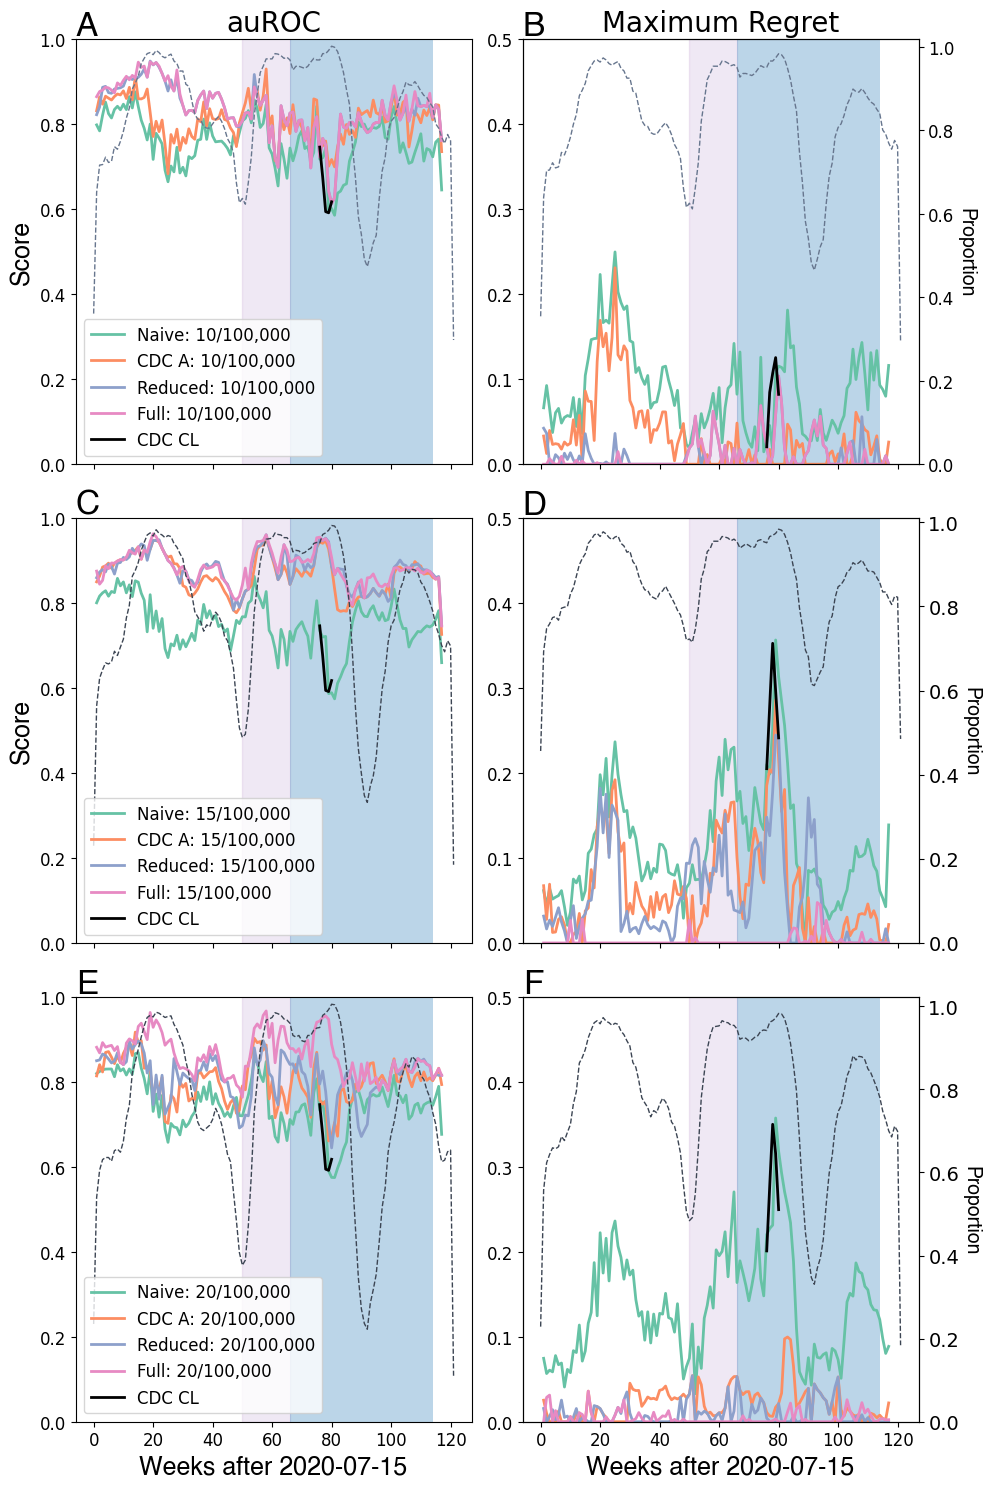

In [106]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharex = 'all')
axs = axs.ravel()

weeks_to_predict = range(1, 118)

axs[0].plot(weeks_to_predict,  list(ROC_thresholds_naive.values())[0], label='Naive: 10/100,000', linewidth = 2, color = palette[0])
axs[0].plot(weeks_to_predict,  list(ROC_thresholds_CDC_A.values())[0], label='CDC A: 10/100,000', linewidth = 2, color = palette[1])
axs[0].plot(weeks_to_predict,  list(ROC_thresholds_no_c_d.values())[0], label='Reduced: 10/100,000', linewidth = 2, color = palette[2])
axs[0].plot(weeks_to_predict,  list(ROC_thresholds.values())[0], label='Full: 10/100,000', linewidth = 2, color = palette[3])
axs[0].plot(range(76, 81), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')

axs[2].plot(weeks_to_predict,  ROC_by_week_naive_exact, label='Naive: 15/100,000', linewidth = 2, color = palette[0])
axs[2].plot(weeks_to_predict,  ROC_by_week_CDC_A_exact, label='CDC A: 15/100,000', linewidth = 2, color = palette[1])
axs[2].plot(weeks_to_predict,  ROC_by_week_full_exact_removed, label='Reduced: 15/100,000', linewidth = 2, color = palette[2])
axs[2].plot(weeks_to_predict,  ROC_by_week_full_exact, label='Full: 15/100,000', linewidth = 2, color = palette[3])
axs[2].plot(range(76, 81), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')

axs[4].plot(weeks_to_predict,  list(ROC_thresholds_naive.values())[1], label='Naive: 20/100,000', linewidth = 2, color = palette[0])
axs[4].plot(weeks_to_predict,  list(ROC_thresholds_CDC_A.values())[1], label='CDC A: 20/100,000', linewidth = 2, color = palette[1])
axs[4].plot(weeks_to_predict,  list(ROC_thresholds_no_c_d.values())[1], label='Reduced: 20/100,000', linewidth = 2, color = palette[2])
axs[4].plot(weeks_to_predict,  list(ROC_thresholds.values())[1], label='Full: 20/100,000', linewidth = 2, color = palette[3])
axs[4].plot(range(76, 81), ROC_by_week_CL_mod[76:81], label='CDC CL', linewidth=2, color='black')

axs[0].plot(range(0, len(list(exceed_threshold.values())[0])), list(exceed_threshold.values())[1], label='', linewidth = 1, color = '#67768E', linestyle = '--')
axs[2].plot(range(0, len(exceed_threshold_15)), exceed_threshold_15, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
axs[4].plot(range(0, len(list(exceed_threshold.values())[1])), list(exceed_threshold.values())[2], label='', linewidth = 1, color = '#3C4553', linestyle = '--')


axs[0].set_title("auROC",fontsize=20)

# Plot MR 
second_axs = axs[1].twinx()
for i, model in enumerate(models_10):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[1].plot(range(76, 81), maximum_regret_by_model_ROC_10[model][76:81], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[1].plot(weeks_to_predict, maximum_regret_by_model_ROC_10[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(list(exceed_threshold.values())[1])), list(exceed_threshold.values())[1], label='', linewidth = 1, color = '#67768E', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

second_axs.tick_params(axis='both', which='major', labelsize=12)
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)
axs[1].set_ylim(0,0.5)
axs[3].set_ylim(0,0.5)

second_axs = axs[3].twinx()
for i, model in enumerate(models_15):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[3].plot(range(76, 81), maximum_regret_by_model_ROC_15[model][76:81], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[3].plot(weeks_to_predict, maximum_regret_by_model_ROC_15[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(list(exceed_threshold.values())[0])), list(exceed_threshold.values())[0], label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.tick_params(axis='y', labelsize=14)
second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)

second_axs = axs[5].twinx()
for i, model in enumerate(models_20):
    colour = palette[i]
    if model == 'CDC CL':
        colour = 'black'
        axs[5].plot(range(76, 81), maximum_regret_by_model_ROC_20[model][76:81], label=model, linestyle = '-', color = colour, linewidth=2)
    else:
        axs[5].plot(weeks_to_predict, maximum_regret_by_model_ROC_20[model], label=model, linestyle = '-', color = colour, linewidth=2)
second_axs.plot(range(0, len(exceed_threshold_15)), exceed_threshold_15, label='', linewidth = 1, color = '#3C4553', linestyle = '--')
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.tick_params(axis='y', labelsize=14)


second_axs.set_ylabel('Proportion',**hfont, rotation=-90, fontsize = 14,  labelpad=15)
axs[1].set_title("Maximum Regret",fontsize=20)

for i in range( len(axs)):
    print(i)
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                        alpha=0.3)
    axs[i].add_patch(polygon_omricon)
axs[0].set_ylabel('Score',**hfont,  fontsize = 18)
axs[2].set_ylabel('Score',**hfont,  fontsize = 18)
second_axs.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
second_axs.tick_params(axis='y', labelsize=14)

axs[0].set_ylim(0,1)
axs[2].set_ylim(0,1)
axs[4].set_ylim(0,1)

axs[1].set_ylim(0,0.5)
axs[3].set_ylim(0,0.5)
axs[5].set_ylim(0,0.5)

axs[4].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[5].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 1, loc='lower left', fontsize='12')
axs[2].legend(ncol = 1, loc='lower left', fontsize='12')
axs[4].legend(ncol = 1, loc='lower left', fontsize='12')

plt.tight_layout()

plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_MR_naive_and_full_removed_expanding_train_models_exact_{size_of_test_dataset}_week_hospitalization_threshold_by_metric.png', dpi = 300, bbox_inches='tight' )